In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install openpyxl
!pip install prophet
!pip install statsmodels
import openpyxl
# from google.colab import drive
# drive.mount('/content/drive')

#Verileri bir dataframe içerisine alıyoruz.


In [2]:
df = pd.read_excel('/content/drive/MyDrive/Makine_verisi/SENSÖR VERİLERİ.xlsx')
df_uretim =pd.read_excel('/content/drive/MyDrive/UretimVerileri-2024_06_01-13_H.xlsx')

#Veri Analizi ve Görselleştirme

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   ID      1048575 non-null  int64 
 1   Date    1048575 non-null  object
 2   A       1048575 non-null  int64 
 3   B       1048575 non-null  int64 
 4   C       1048575 non-null  int64 
 5   D       1048575 non-null  int64 
 6   E       1048575 non-null  int64 
 7   F       1048575 non-null  int64 
 8   G       1048575 non-null  int64 
 9   H       1048575 non-null  int64 
 10  I       1048575 non-null  int64 
 11  J       1048575 non-null  int64 
 12  K       1048575 non-null  int64 
 13  L       1048575 non-null  int64 
 14  M       1048575 non-null  int64 
 15  N       1048575 non-null  int64 
 16  O       1048575 non-null  int64 
 17  P       1048575 non-null  int64 
 18  R       1048575 non-null  int64 
 19  S       1048575 non-null  int64 
dtypes: int64(19), object(1)
memory usage: 160.0+ M

In [4]:
df_uretim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Uretimtarihi  1164 non-null   datetime64[ns]
 1   Vardiya       1164 non-null   object        
 2   Mak.No        1164 non-null   object        
 3   UrunKod       1164 non-null   object        
 4   UretimAdet    1164 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.6+ KB


In [5]:
df.head()

,ID,Date,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,R,S
0,184907763,2024-06-01 00:00:00.2333779,90,379,0,438,134,0,0,0,0,165,122,57,0,209,59,141,41,150
1,184907764,2024-06-01 00:00:01.2490019,95,377,0,441,134,0,0,0,0,165,124,57,0,274,61,143,48,154
2,184907765,2024-06-01 00:00:02.2489939,92,381,0,436,134,0,0,0,0,166,122,57,0,241,61,140,57,149
3,184907766,2024-06-01 00:00:03.2490006,89,377,0,437,134,0,0,0,0,165,124,59,0,312,61,143,65,152
4,184907767,2024-06-01 00:00:04.2646202,92,382,0,441,134,0,0,0,0,165,124,56,0,337,62,141,46,148


In [6]:
df_uretim.head()

,Uretimtarihi,Vardiya,Mak.No,UrunKod,UretimAdet
0,2024-06-01,24:00 / 08:00,D,27B00656A9447ABD130D301FE4CFC6CAF4B212FC538B1D...,17
1,2024-06-01,24:00 / 08:00,D,9F0BBFA0E6E71C58B870A45DE9BA68D76940B6A5983F5E...,20
2,2024-06-01,24:00 / 08:00,S,9BC70C1EF336B4821DC5191CC63CE17BE1FD36E64BBB97...,24
3,2024-06-01,24:00 / 08:00,S,668D456CF4236AF1CD60E34C778E576828DC9B7A6E2BF9...,21
4,2024-06-01,24:00 / 08:00,R,CF88BE45591D8DC16BCB78768B08C1B38CB133E3652545...,181


In [7]:
df_uretim['Vardiya'].value_counts()

,count
Vardiya,
08:00 / 16:00,423
16:00 / 24:00,403
24:00 / 08:00,336
08:00 / 10:00,2


In [8]:
df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", format="%Y-%m-%d %H:%M:%S.%f")
machine_cols = [c for c in df.columns if c not in ("ID", "Date")]

df[machine_cols] = df[machine_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
df = df.sort_values("Date").set_index("Date")

# 1 dakikalık ortalamalar
df_min = (
    df[machine_cols]
    .resample("T").mean()
    .reset_index()
    .rename(columns={"Date": "minute"})
)

# 1 saatlik ortalamalar
df_hour = (
    df[machine_cols]
    .resample("H").mean()
    .reset_index()
    .rename(columns={"Date": "hour"})
)

# 8 saatlik sabit vardiya ortalamaları (08-16, 16-24, 24-08)
df_8h = (
    df[machine_cols]
    .resample("8H", origin="start_day", offset="8H")  # vardiya başlangıçları: 08:00, 16:00, 00:00
    .mean()
    .reset_index()
    .rename(columns={"Date": "shift_start"})
)

# Vardiya etiketi (ör. "08:00 / 16:00", "16:00 / 24:00", "24:00 / 08:00")
df_8h["shift_end"] = df_8h["shift_start"] + pd.Timedelta(hours=8)

def _fmt(t):
    return "24:00" if (t.hour == 0 and t.minute == 0) else t.strftime("%H:%M")

df_8h["shift"] = df_8h.apply(
    lambda r: f"{_fmt(r['shift_start'])} / {_fmt(r['shift_end'])}", axis=1
)

# Kolon sıralaması
df_8h = df_8h[["shift_start", "shift_end", "shift"] + [c for c in df_8h.columns if c in machine_cols]]


/tmp/ipython-input-1605911681.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("T").mean()
/tmp/ipython-input-1605911681.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H").mean()
/tmp/ipython-input-1605911681.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("8H", origin="start_day", offset="8H")  # vardiya başlangıçları: 08:00, 16:00, 00:00
/tmp/ipython-input-1605911681.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  .resample("8H", origin="start_day", offset="8H")  # vardiya başlangıçları: 08:00, 16:00, 00:00


In [9]:
df_hour.head()

,hour,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,R,S
0,2024-06-01 00:00:00,509.485278,264.774167,89.893056,354.018056,147.684167,94.260278,77.985278,0.0,0.0,167.273889,337.969722,332.417500,153.003056,110.877500,152.140278,141.414167,60.423056,104.227500
1,2024-06-01 01:00:00,527.043889,142.257778,96.868611,243.215833,113.573333,85.801389,54.495000,0.0,0.0,181.704444,264.373889,136.206944,232.168889,116.204722,211.405556,135.287222,59.187500,150.441944
2,2024-06-01 02:00:00,499.166389,287.013056,96.932222,330.711944,132.325556,213.360556,50.613333,0.0,0.0,115.141944,280.549167,278.405278,152.467222,109.864167,198.640833,141.400278,60.284722,109.821944
3,2024-06-01 03:00:00,494.920278,362.967222,71.162500,302.788056,97.713333,173.550000,65.848611,0.0,0.0,156.715833,270.117222,378.588333,208.980278,102.739167,172.762500,120.247500,60.391111,107.981944
4,2024-06-01 04:00:00,191.807222,154.774167,39.781667,150.688333,19.743056,51.243889,30.611389,0.0,0.0,77.549444,127.478333,179.230556,90.114722,53.768056,0.000000,63.313889,31.270833,1.237222


In [10]:
df_8h.head()

,shift_start,shift_end,shift,A,B,C,D,E,F,G,...,I,J,K,L,M,N,O,P,R,S
0,2024-06-01 00:00:00,2024-06-01 08:00:00,24:00 / 08:00,456.032882,255.779375,83.240764,273.364514,118.447014,133.457882,50.876528,...,0.0,134.493889,271.700799,210.695278,175.694861,102.554653,168.912118,128.149549,53.530764,100.640694
1,2024-06-01 08:00:00,2024-06-01 16:00:00,08:00 / 16:00,405.785208,207.430764,23.806562,204.728264,145.030868,158.616285,53.569896,...,0.0,102.170799,327.619861,292.393542,269.028194,110.035278,225.269583,127.818646,13.265868,140.820347
2,2024-06-01 16:00:00,2024-06-02 00:00:00,16:00 / 24:00,326.118611,281.316667,102.736910,211.737118,74.981250,191.766944,180.276979,...,0.0,130.877014,334.982431,255.873993,293.013194,101.068542,236.692014,116.576597,57.356319,131.523889
3,2024-06-02 00:00:00,2024-06-02 08:00:00,24:00 / 08:00,430.630278,1.677153,101.062153,202.330312,0.813750,149.714479,220.444444,...,0.0,0.000000,145.267292,259.090243,318.467049,87.886632,0.000000,123.884965,50.927049,123.505729
4,2024-06-02 08:00:00,2024-06-02 16:00:00,08:00 / 16:00,355.382986,302.118438,91.512917,267.091493,145.203438,86.511250,0.000000,...,0.0,79.477535,205.201042,219.877604,265.828715,102.179861,219.921285,116.366840,0.802083,146.748056


In [11]:
df_8h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   shift_start  37 non-null     datetime64[ns]
 1   shift_end    37 non-null     datetime64[ns]
 2   shift        37 non-null     object        
 3   A            37 non-null     float64       
 4   B            37 non-null     float64       
 5   C            37 non-null     float64       
 6   D            37 non-null     float64       
 7   E            37 non-null     float64       
 8   F            37 non-null     float64       
 9   G            37 non-null     float64       
 10  H            37 non-null     float64       
 11  I            37 non-null     float64       
 12  J            37 non-null     float64       
 13  K            37 non-null     float64       
 14  L            37 non-null     float64       
 15  M            37 non-null     float64       
 16  N         

In [12]:
df_min.head()

,minute,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,R,S
0,2024-06-01 00:00:00,216.200000,285.550000,0.00,438.583333,133.900000,0.0,0.0,0.0,0.0,165.150000,122.900000,57.250000,91.600000,125.933333,61.083333,141.583333,56.050000,152.116667
1,2024-06-01 00:01:00,457.266667,342.216667,0.00,438.583333,134.033333,0.0,0.0,0.0,0.0,164.983333,122.966667,57.400000,322.233333,135.183333,61.066667,141.483333,55.666667,179.633333
2,2024-06-01 00:02:00,0.000000,378.650000,0.00,152.133333,134.066667,0.0,0.0,0.0,0.0,164.800000,377.483333,271.083333,276.916667,73.616667,61.150000,141.466667,57.666667,179.100000
3,2024-06-01 00:03:00,22.216667,248.633333,22.80,263.616667,133.883333,0.0,0.0,0.0,0.0,164.500000,122.850000,401.850000,298.633333,124.783333,61.050000,141.483333,60.050000,179.700000
4,2024-06-01 00:04:00,32.450000,378.700000,103.15,438.450000,133.966667,0.0,0.0,0.0,0.0,164.566667,122.733333,370.666667,322.416667,101.916667,331.833333,141.316667,61.083333,179.183333


In [13]:
filter = df_uretim['Mak.No'] == 'A'
df_uretim[filter].head()

,Uretimtarihi,Vardiya,Mak.No,UrunKod,UretimAdet
27,2024-06-01,24:00 / 08:00,A,5539857A99AFD7285447EFB3A806E9CD21185E6FE9B95E...,45
28,2024-06-01,24:00 / 08:00,A,A25828FAA53A8A79BF01C31C9EEB8D91EB72AFD795D825...,20
29,2024-06-01,24:00 / 08:00,A,A25828FAA53A8A79BF01C31C9EEB8D91EB72AFD795D825...,100
33,2024-06-01,08:00 / 16:00,A,5539857A99AFD7285447EFB3A806E9CD21185E6FE9B95E...,5
34,2024-06-01,08:00 / 16:00,A,1B050099747DC84AE48934C5170ACF4A084C34E52ACEDB...,15


/tmp/ipython-input-3780922022.py:66: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_hour.pivot_table(


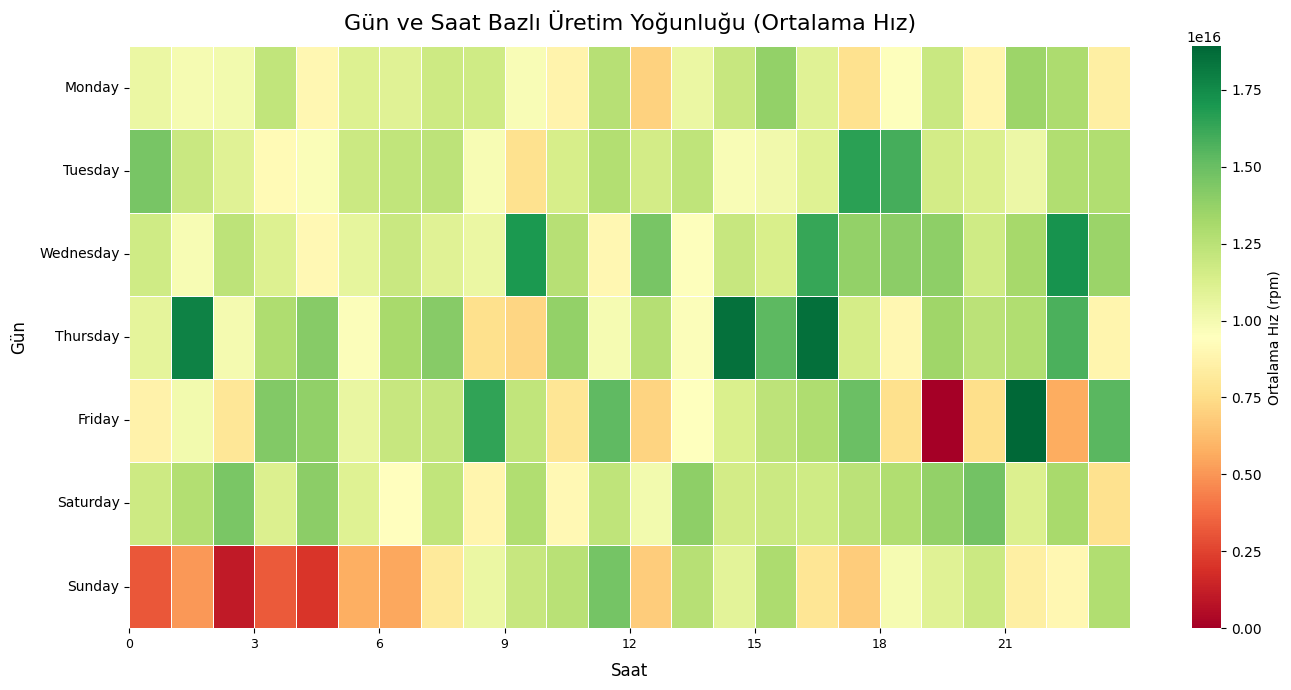

In [14]:
time_col = None
for c in df_hour.columns:
    if c.lower() in ["hour", "date", "tarih", "timestamp"]:
        time_col = c
        break
if time_col is None:
    raise ValueError("Saat/tarih kolonu bulunamadı (hour/date/tarih/timestamp).")

df_hour = df_hour.copy()
df_hour.columns = df_hour.columns.str.strip()
df_hour[time_col] = pd.to_datetime(df_hour[time_col], errors="coerce")
if df_hour[time_col].isna().any():
    raise ValueError("Saat/tarih parse edilemedi.")

exclude_now = {time_col, "ortalama_hiz", "hour_only", "day_of_week", "day_name"}
candidate_cols = [c for c in df_hour.columns if c not in exclude_now]

def coerce_numeric(series: pd.Series) -> pd.Series:
    """Binlik ayraçları ve Türkçe ondalık virgülü temizleyerek numeriğe çevirir."""
    s = series.astype(str).str.strip()
    s = s.replace({"": np.nan, "-": np.nan, "NA": np.nan, "NaN": np.nan, "None": np.nan})

    sample = s.dropna().head(1000)
    comma_decimal = (sample.str.contains(",") & ~sample.str.contains(r"\.\d{1,3},\d")).sum() >= \
                    (sample.str.contains(r"\d,\d+").sum())

    if comma_decimal:

        s = s.str.replace(".", "", regex=False)
        s = s.str.replace(",", ".", regex=False)
    else:

        s = s.str.replace(",", "", regex=False)

    return pd.to_numeric(s, errors="coerce")

cleaned = {}
for c in candidate_cols:
    cleaned[c] = coerce_numeric(df_hour[c])

clean_df = pd.DataFrame(cleaned)

machine_cols = []
for c in clean_df.columns:
    valid_ratio = clean_df[c].notna().mean()
    if valid_ratio >= 0.7:
        machine_cols.append(c)

if not machine_cols:
    raise ValueError("Makine kolonları tespit edilemedi; veri biçimini kontrol edin.")

for c in machine_cols:
    df_hour[c] = clean_df[c]

df_hour["ortalama_hiz"] = df_hour[machine_cols].mean(axis=1, skipna=True)

df_hour["hour_only"]   = df_hour[time_col].dt.hour
df_hour["day_of_week"] = df_hour[time_col].dt.dayofweek  # Pazartesi=0 ... Pazar=6
day_map = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
df_hour["day_name"] = pd.Categorical(
    df_hour["day_of_week"].map(day_map),
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)

pivot_table = df_hour.pivot_table(
    values="ortalama_hiz",
    index="day_name",
    columns="hour_only",
    aggfunc="mean"
).sort_index()


plt.figure(figsize=(14, 7))

ax = sns.heatmap(
    pivot_table,
    cmap="RdYlGn",
    annot=False,
    fmt=".0f",
    annot_kws={"size": 8},
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Ortalama Hız (rpm)"}
)

ax.set_title("Gün ve Saat Bazlı Üretim Yoğunluğu (Ortalama Hız)", fontsize=16, pad=12)
ax.set_xlabel("Saat", fontsize=12, labelpad=8)
ax.set_ylabel("Gün", fontsize=12, labelpad=8)

hours = list(pivot_table.columns)
tick_positions = [i for i, h in enumerate(hours) if (int(h) % 3 == 0)]
tick_labels = [str(hours[i]) for i in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha="center", fontsize=9)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

#Makine Karşılaştırması (En Verimli / En Yavaş)

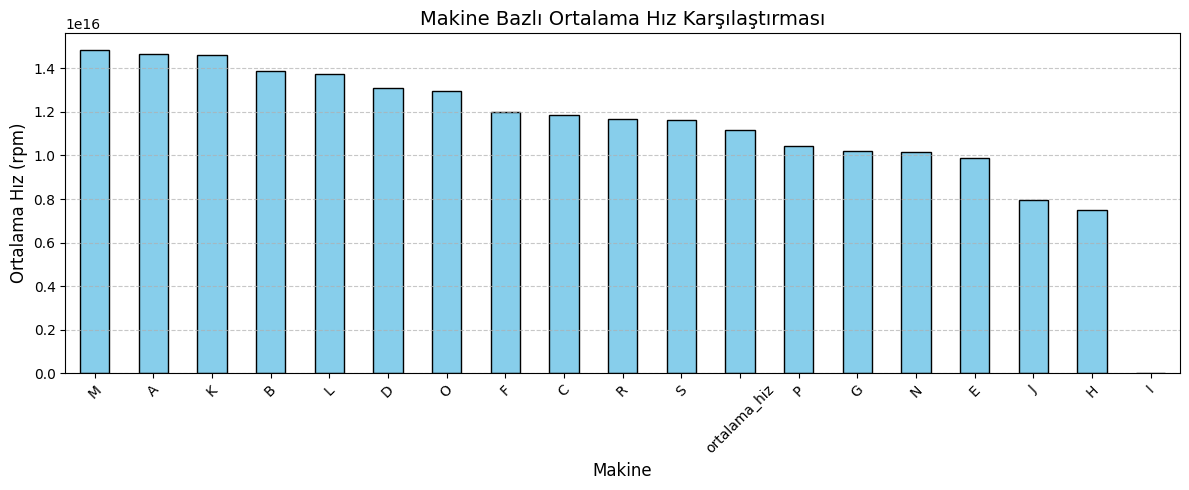

In [15]:
# Kopya alalım ki orijinali bozulmasın
df_num = df_hour.copy()

# Sütun adlarından sadece numerik olanları seç
num_cols = df_num.select_dtypes(include=["number"]).columns

# Eğer 'hour' gibi zaman kolonları numeric ise onları hariç tut
exclude_cols = {"hour_only", "day_of_week"}
machine_cols = [c for c in num_cols if c not in exclude_cols]

# Ortalama hız hesapla
makine_ortalama = df_num[machine_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
makine_ortalama.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Makine Bazlı Ortalama Hız Karşılaştırması", fontsize=14)
plt.xlabel("Makine", fontsize=12)
plt.ylabel("Ortalama Hız (rpm)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#Pik ve Dip Saatler (Ortalama Hız)

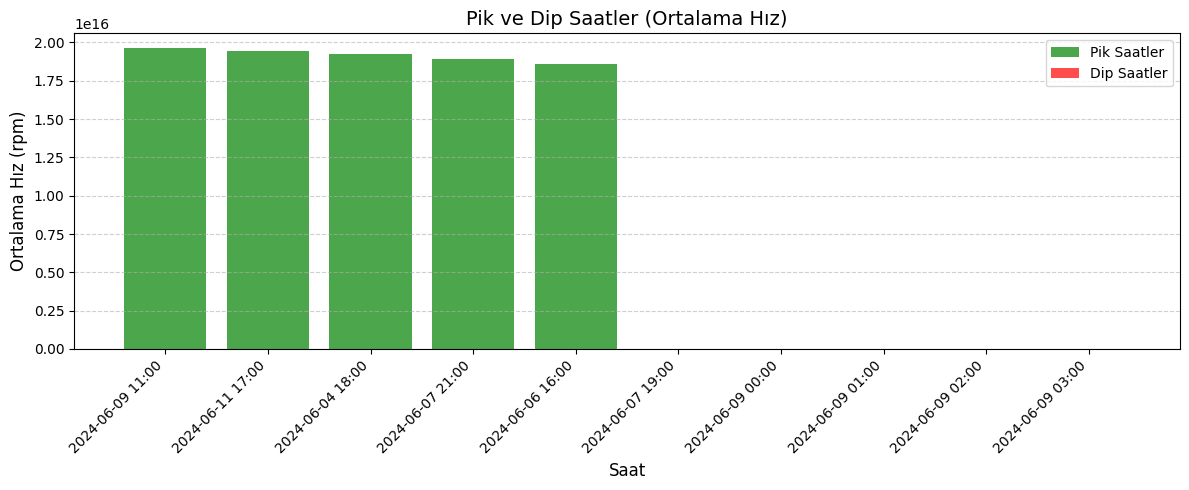

In [16]:
pikler = df_hour.nlargest(5, "ortalama_hiz")[["hour", "ortalama_hiz"]]

dipler = df_hour.nsmallest(5, "ortalama_hiz")[["hour", "ortalama_hiz"]]

pikler_plot = pikler.copy()
pikler_plot["hour_str"] = pd.to_datetime(pikler_plot["hour"]).dt.strftime("%Y-%m-%d %H:%M")

dipler_plot = dipler.copy()
dipler_plot["hour_str"] = pd.to_datetime(dipler_plot["hour"]).dt.strftime("%Y-%m-%d %H:%M")

# Grafik
plt.figure(figsize=(12, 5))

# Pik saatler (yeşil)
plt.bar(pikler_plot["hour_str"], pikler_plot["ortalama_hiz"], color="green", alpha=0.7, label="Pik Saatler")

# Dip saatler (kırmızı)
plt.bar(dipler_plot["hour_str"], dipler_plot["ortalama_hiz"], color="red", alpha=0.7, label="Dip Saatler")

plt.title("Pik ve Dip Saatler (Ortalama Hız)", fontsize=14)
plt.xlabel("Saat", fontsize=12)
plt.ylabel("Ortalama Hız (rpm)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


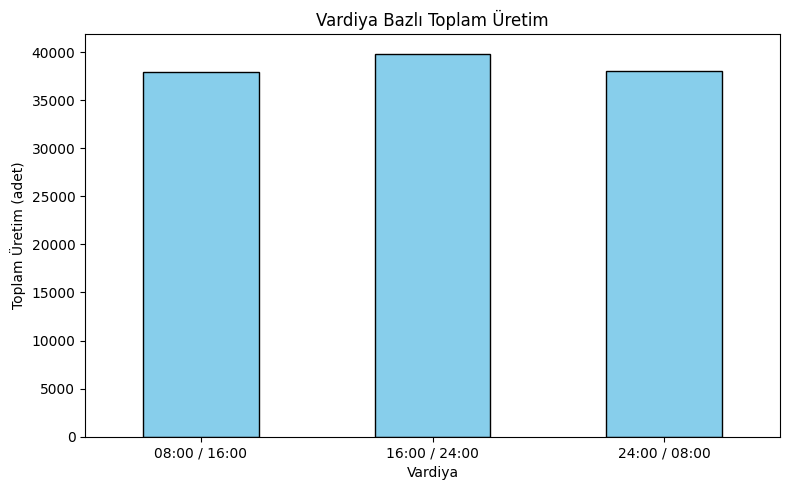

=== Vardiya Bazlı Toplam Üretim ===
                     Toplam
shift                      
08:00 / 16:00  37876.707531
16:00 / 24:00  39842.451161
24:00 / 08:00  38030.202921

=== Vardiya Bazlı Ortalama Üretim ===
                 Ortalama
shift                    
08:00 / 16:00  175.355127
16:00 / 24:00  184.455792
24:00 / 08:00  162.522235


In [17]:

# Makine kolonlarını seç
machine_cols = [c for c in df_8h.columns if c not in ["shift_start", "shift_end", "shift"]]

# Vardiya bazlı toplam üretim
vardiya_toplam = df_8h.groupby("shift")[machine_cols].sum()
vardiya_toplam["Toplam"] = vardiya_toplam.sum(axis=1)

# Vardiya bazlı ortalama üretim
vardiya_ortalama = df_8h.groupby("shift")[machine_cols].mean()
vardiya_ortalama["Ortalama"] = vardiya_ortalama.mean(axis=1)

# Grafik: Vardiya bazlı toplam üretim
plt.figure(figsize=(8,5))
vardiya_toplam["Toplam"].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Vardiya Bazlı Toplam Üretim")
plt.ylabel("Toplam Üretim (adet)")
plt.xlabel("Vardiya")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("=== Vardiya Bazlı Toplam Üretim ===")
print(vardiya_toplam[["Toplam"]])
print("\n=== Vardiya Bazlı Ortalama Üretim ===")
print(vardiya_ortalama[["Ortalama"]])


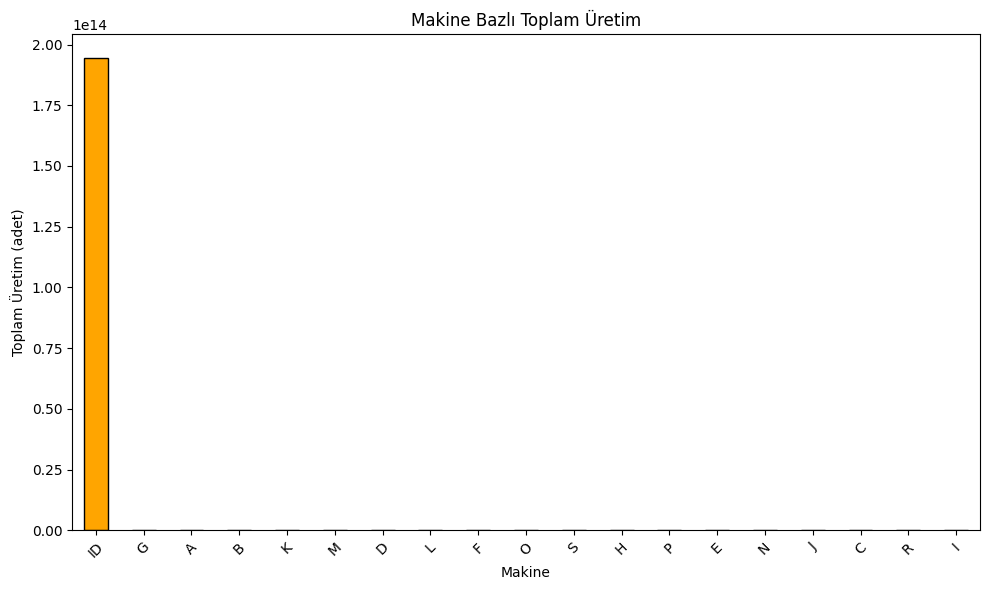

=== Makine Bazlı Toplam Üretim ===
ID    194439874113890
G           417201924
A           406806791
B           262954478
K           261044837
M           253399181
D           243036891
L           226867990
F           195708049
O           191780436
S           154479043
H           132542355
P           127503936
E           126001558
N            78673332
J            77016224
C            64239650
R            49711132
I                   0
dtype: int64

=== Makine Bazlı Ortalama Üretim ===
ID    1.854325e+08
G     3.978751e+02
A     3.879616e+02
B     2.507732e+02
K     2.489520e+02
M     2.416605e+02
D     2.317783e+02
L     2.163584e+02
F     1.866419e+02
O     1.828963e+02
S     1.473228e+02
H     1.264024e+02
P     1.215973e+02
E     1.201646e+02
N     7.502881e+01
J     7.344846e+01
C     6.126376e+01
R     4.740828e+01
I     0.000000e+00
dtype: float64

En yüksek üretim yapan makine: ('ID', 194439874113890)
En düşük üretim yapan makine: ('I', 0)


In [18]:
machine_cols = [c for c in df.columns if c not in ["shift_start", "shift_end", "shift"]]

# Makine bazlı toplam ve ortalama üretim
makine_toplam = df[machine_cols].sum().sort_values(ascending=False)
makine_ortalama = df[machine_cols].mean().sort_values(ascending=False)

# En yüksek ve en düşük üretim yapan makineler
en_yuksek = makine_toplam.idxmax(), makine_toplam.max()
en_dusuk = makine_toplam.idxmin(), makine_toplam.min()

# Grafik
plt.figure(figsize=(10,6))
makine_toplam.plot(kind="bar", color="orange", edgecolor="black")
plt.title("Makine Bazlı Toplam Üretim")
plt.ylabel("Toplam Üretim (adet)")
plt.xlabel("Makine")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("=== Makine Bazlı Toplam Üretim ===")
print(makine_toplam)
print("\n=== Makine Bazlı Ortalama Üretim ===")
print(makine_ortalama)
print("\nEn yüksek üretim yapan makine:", en_yuksek)
print("En düşük üretim yapan makine:", en_dusuk)

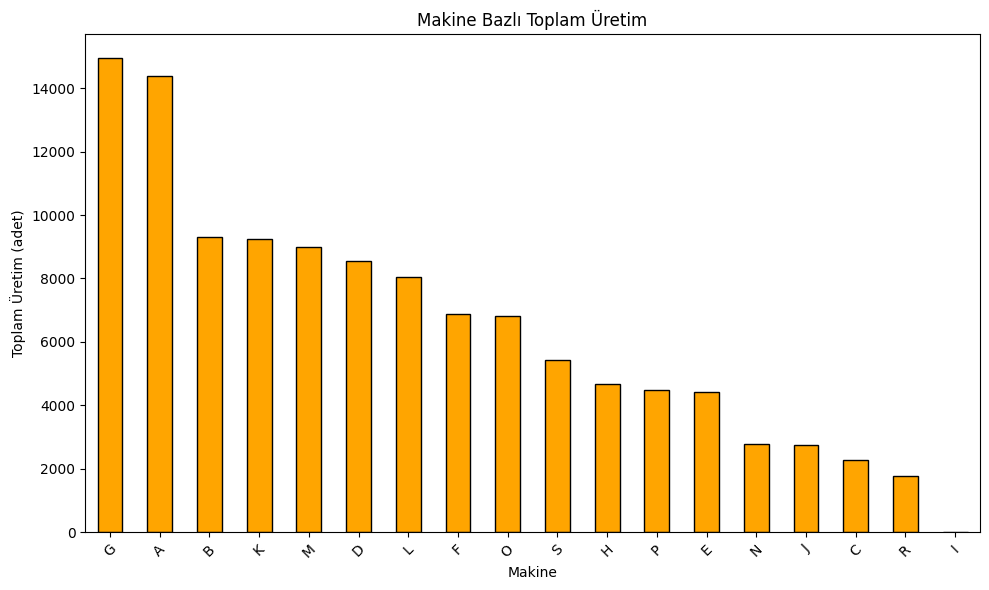

=== Makine Bazlı Toplam Üretim ===
G    14944.554201
A    14383.065928
B     9295.329786
K     9252.669657
M     8988.291896
D     8544.689089
L     8059.812055
F     6874.525894
O     6821.217685
S     5436.207960
H     4659.455254
P     4493.819183
E     4434.508474
N     2780.517893
J     2744.860674
C     2265.373430
R     1770.462554
I        0.000000
dtype: float64

=== Makine Bazlı Ortalama Üretim ===
G    403.906870
A    388.731512
B    251.225129
K    250.072153
M    242.926808
D    230.937543
L    217.832758
F    185.797997
O    184.357235
S    146.924539
H    125.931223
P    121.454573
E    119.851580
N     75.149132
J     74.185424
C     61.226309
R     47.850339
I      0.000000
dtype: float64

En yüksek üretim yapan makine: ('G', 14944.554201016967)
En düşük üretim yapan makine: ('I', 0.0)


In [19]:
machine_cols = [c for c in df_8h.columns if c not in ["shift_start", "shift_end", "shift"]]

# Makine bazlı toplam ve ortalama üretim
makine_toplam = df_8h[machine_cols].sum().sort_values(ascending=False)
makine_ortalama = df_8h[machine_cols].mean().sort_values(ascending=False)

# En yüksek ve en düşük üretim yapan makineler
en_yuksek = makine_toplam.idxmax(), makine_toplam.max()
en_dusuk = makine_toplam.idxmin(), makine_toplam.min()

# Grafik
plt.figure(figsize=(10,6))
makine_toplam.plot(kind="bar", color="orange", edgecolor="black")
plt.title("Makine Bazlı Toplam Üretim")
plt.ylabel("Toplam Üretim (adet)")
plt.xlabel("Makine")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("=== Makine Bazlı Toplam Üretim ===")
print(makine_toplam)
print("\n=== Makine Bazlı Ortalama Üretim ===")
print(makine_ortalama)
print("\nEn yüksek üretim yapan makine:", en_yuksek)
print("En düşük üretim yapan makine:", en_dusuk)

En çok üretilen ürün: ('2CF0B8FAD0ED19279079209B6F55FCEDC1BE198121C83226D7C67172D453FC98', 8213)

En çok üretilen ürün için makine dağılımı:
                                               UrunKod Mak.No  UretimAdet
61  2CF0B8FAD0ED19279079209B6F55FCEDC1BE198121C832...      I        3518
62  2CF0B8FAD0ED19279079209B6F55FCEDC1BE198121C832...      P        4695

Ürünlerin toplam üretimdeki payı (ilk 10):
 UrunKod
2CF0B8FAD0ED19279079209B6F55FCEDC1BE198121C83226D7C67172D453FC98    10.511967
17CE4501EC8F381453B61E5927F9A6EE387B32BE4823266E583FEF0854C4A876     3.793677
37FF79997F5FDBB5C51DE327483156A827D40AA3CA2CCABF792DFB9F89CDCE41     3.528734
550C7617FA61B98D77CAE6DF4A06E9930BD986065D9A19886EDC98752A28CDB2     3.352105
FDEA7527595E5B90E02ACE6733152A3F580F25B7FC32C4B8E58CE4B6DC60F584     3.030846
6FB8D7D3E86604E1C14AD6B9D4BDC21D0D16927521C433F2B674984F1C1DD9C2     2.132344
C836061B9F1B8BEE9549F7DEA4253C7AE4B7E7D48259895E19B6B7C34B724D59     2.009471
E0C8B35047EAF84C9C864A9133D24622B7DADA41

/tmp/ipython-input-3080401205.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


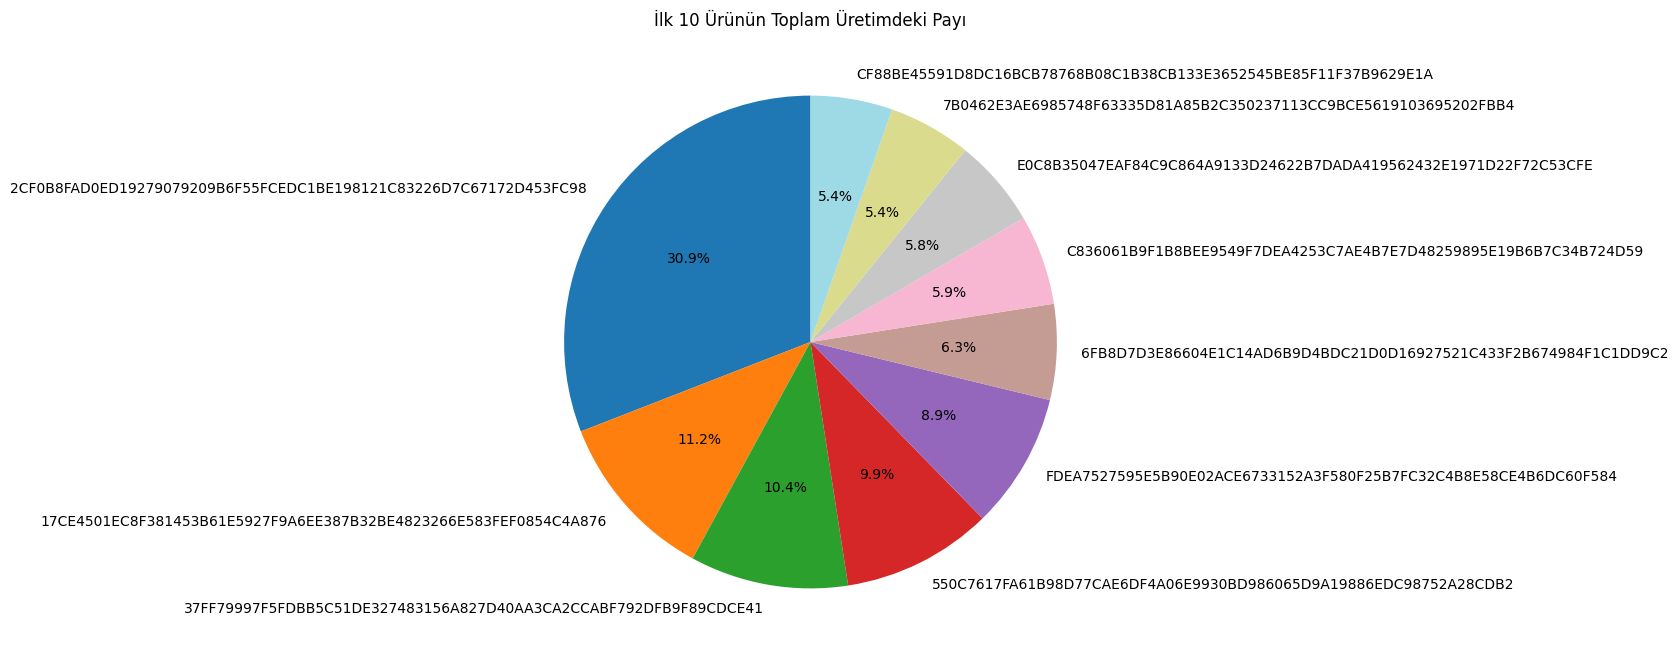

In [20]:
# Ürün bazlı toplam üretim
urun_toplam = df_uretim.groupby("UrunKod")["UretimAdet"].sum().sort_values(ascending=False)

# 1. En çok üretilen ürün
en_cok_uretilen = urun_toplam.idxmax(), urun_toplam.max()
print("En çok üretilen ürün:", en_cok_uretilen)

# 2. Ürün-makine dağılımı
urun_makine = df_uretim.groupby(["UrunKod", "Mak.No"])["UretimAdet"].sum().reset_index()
urun_top_makine = urun_makine[urun_makine["UrunKod"] == en_cok_uretilen[0]]
print("\nEn çok üretilen ürün için makine dağılımı:\n", urun_top_makine)

# 3. Ürünlerin toplam içindeki payı
urun_payi = (urun_toplam / urun_toplam.sum() * 100).sort_values(ascending=False)
print("\nÜrünlerin toplam üretimdeki payı (ilk 10):\n", urun_payi.head(10))

# Pie chart
plt.figure(figsize=(8,8))
urun_payi.head(10).plot(kind="pie", autopct="%1.1f%%", startangle=90, cmap="tab20")
plt.ylabel("")
plt.title("İlk 10 Ürünün Toplam Üretimdeki Payı")
plt.tight_layout()
plt.show()


Vardiya                                             08:00 / 16:00  \
UrunKod                                                             
17CE4501EC8F381453B61E5927F9A6EE387B32BE4823266...            911   
2CF0B8FAD0ED19279079209B6F55FCEDC1BE198121C8322...           2839   
37FF79997F5FDBB5C51DE327483156A827D40AA3CA2CCAB...            839   
550C7617FA61B98D77CAE6DF4A06E9930BD986065D9A198...            815   
FDEA7527595E5B90E02ACE6733152A3F580F25B7FC32C4B...            842   

Vardiya                                             16:00 / 24:00  \
UrunKod                                                             
17CE4501EC8F381453B61E5927F9A6EE387B32BE4823266...            891   
2CF0B8FAD0ED19279079209B6F55FCEDC1BE198121C8322...           2715   
37FF79997F5FDBB5C51DE327483156A827D40AA3CA2CCAB...           1027   
550C7617FA61B98D77CAE6DF4A06E9930BD986065D9A198...            843   
FDEA7527595E5B90E02ACE6733152A3F580F25B7FC32C4B...            777   

Vardiya                         

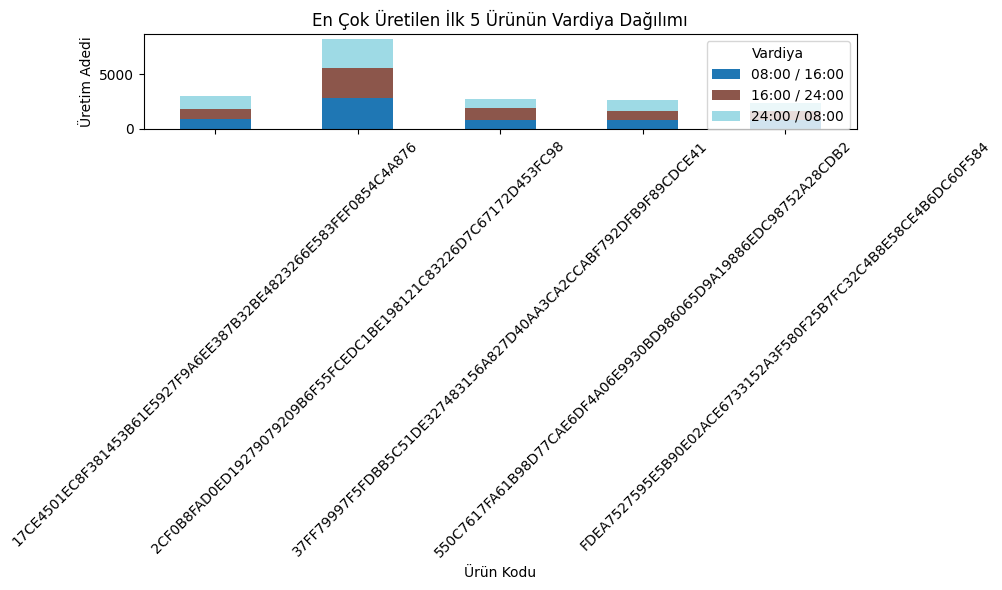

In [21]:
# Ürün bazlı toplam üretim
urun_toplam = df_uretim.groupby("UrunKod")["UretimAdet"].sum().sort_values(ascending=False)

# En çok üretilen ilk 5 ürün
top5_urun = urun_toplam.head(5).index

# Ürün - Vardiya analizi
urun_vardiya = df_uretim.groupby(["UrunKod", "Vardiya"])["UretimAdet"].sum().reset_index()
urun_vardiya_top5 = urun_vardiya[urun_vardiya["UrunKod"].isin(top5_urun)]

# Pivot tablo
pivot_top5 = urun_vardiya_top5.pivot(index="UrunKod", columns="Vardiya", values="UretimAdet").fillna(0)
print(pivot_top5)

# Grafik
pivot_top5.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
plt.title("En Çok Üretilen İlk 5 Ürünün Vardiya Dağılımı")
plt.ylabel("Üretim Adedi")
plt.xlabel("Ürün Kodu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


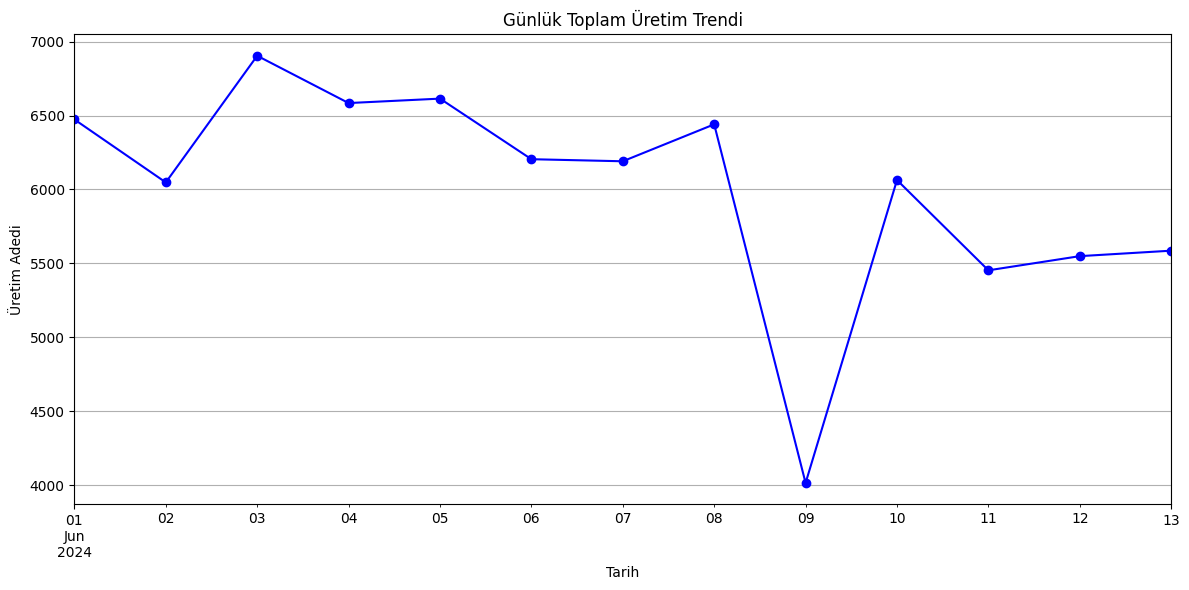

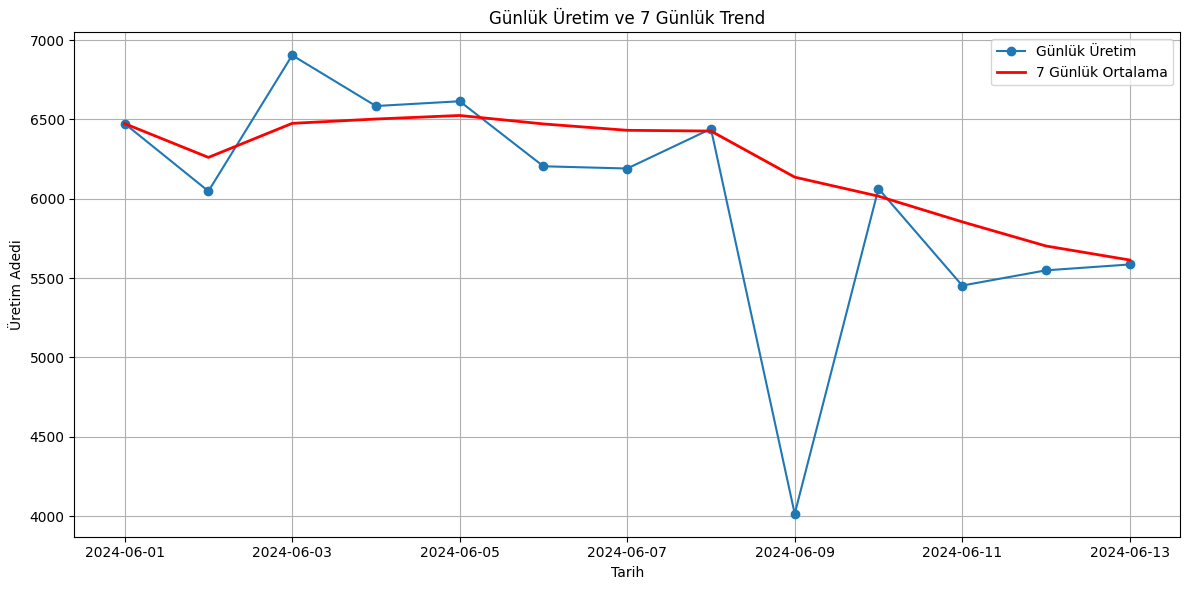

Günlük Üretim İlk 15 Gün:
 Uretimtarihi
2024-06-01    6474
2024-06-02    6048
2024-06-03    6905
2024-06-04    6585
2024-06-05    6615
2024-06-06    6205
2024-06-07    6191
2024-06-08    6441
2024-06-09    4014
2024-06-10    6064
2024-06-11    5453
2024-06-12    5549
2024-06-13    5586
Name: UretimAdet, dtype: int64

7 Günlük Ortalama İlk 15 Gün:
 Uretimtarihi
2024-06-01    6474.000000
2024-06-02    6261.000000
2024-06-03    6475.666667
2024-06-04    6503.000000
2024-06-05    6525.400000
2024-06-06    6472.000000
2024-06-07    6431.857143
2024-06-08    6427.142857
2024-06-09    6136.571429
2024-06-10    6016.428571
2024-06-11    5854.714286
2024-06-12    5702.428571
2024-06-13    5614.000000
Name: UretimAdet, dtype: float64


In [22]:
# Günlük toplam üretim
gunluk_toplam = df_uretim.groupby("Uretimtarihi")["UretimAdet"].sum()

# Grafik 1: Günlük üretim
plt.figure(figsize=(12,6))
gunluk_toplam.plot(marker="o", linestyle="-", color="blue")
plt.title("Günlük Toplam Üretim Trendi")
plt.ylabel("Üretim Adedi")
plt.xlabel("Tarih")
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafik 2: 7 günlük hareketli ortalama
hareketli_ortalama = gunluk_toplam.rolling(window=7, min_periods=1).mean()
plt.figure(figsize=(12,6))
plt.plot(gunluk_toplam.index, gunluk_toplam, marker="o", linestyle="-", label="Günlük Üretim")
plt.plot(hareketli_ortalama.index, hareketli_ortalama, color="red", linewidth=2, label="7 Günlük Ortalama")
plt.title("Günlük Üretim ve 7 Günlük Trend")
plt.ylabel("Üretim Adedi")
plt.xlabel("Tarih")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Günlük Üretim İlk 15 Gün:\n", gunluk_toplam.head(15))
print("\n7 Günlük Ortalama İlk 15 Gün:\n", hareketli_ortalama.head(15))


#Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0at1qo4q/flrtedkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0at1qo4q/6pb0df8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27615', 'data', 'file=/tmp/tmp0at1qo4q/flrtedkd.json', 'init=/tmp/tmp0at1qo4q/6pb0df8z.json', 'output', 'file=/tmp/tmp0at1qo4q/prophet_modelpw1g7_gk/prophet_model-20250828104349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:43:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


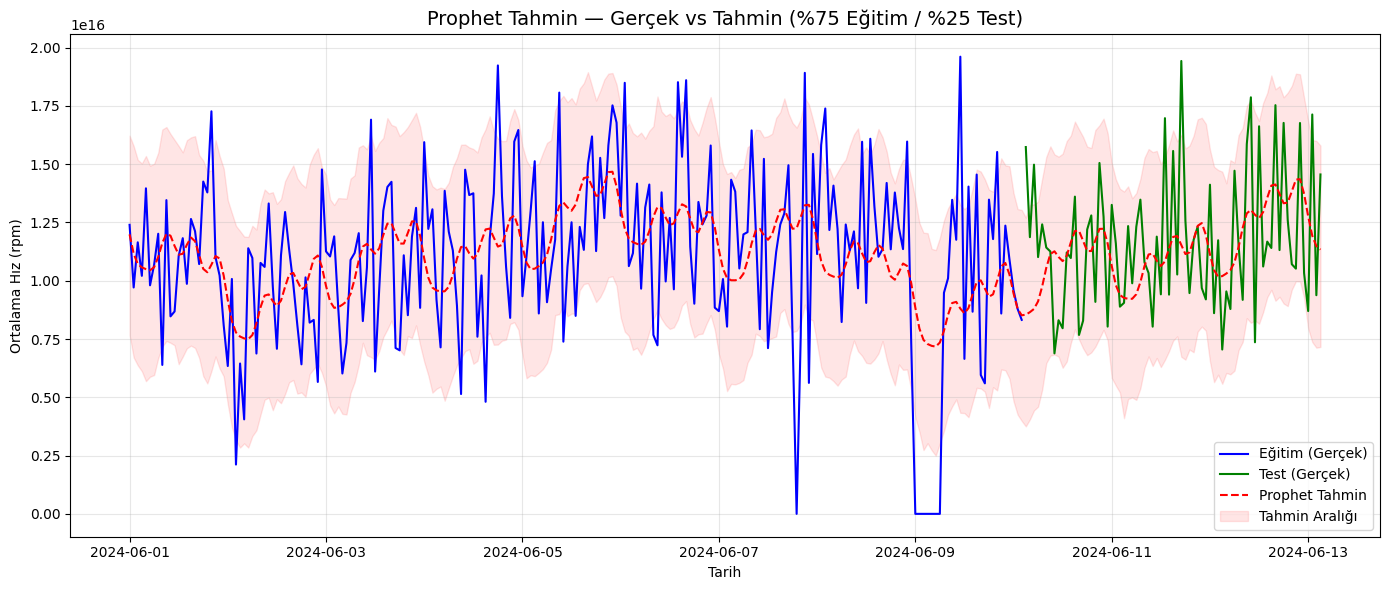

In [23]:
from prophet import Prophet

# ---------------------------
# 1) Veri Hazırlığı
# ---------------------------
# Prophet formatı: ds = tarih, y = hedef değişken
df = df_hour.copy()
df["hour"] = pd.to_datetime(df["hour"], errors="coerce")
df_prophet = df.rename(columns={"hour": "ds", "ortalama_hiz": "y"})[["ds", "y"]]

# Tarihe göre sırala
df_prophet = df_prophet.sort_values("ds").reset_index(drop=True)

# ---------------------------
# 2) Eğitim/Test bölme (%75 / %25)
# ---------------------------
split_index = int(len(df_prophet) * 0.75)
train = df_prophet.iloc[:split_index]
test  = df_prophet.iloc[split_index:]

# ---------------------------
# 3) Prophet Modeli
# ---------------------------
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
model.fit(train)

# ---------------------------
# 4) Tahmin
# ---------------------------
future = model.make_future_dataframe(periods=len(test), freq="H")
forecast = model.predict(future)

# ---------------------------
# 5) Grafik — Gerçek vs Tahmin
# ---------------------------
plt.figure(figsize=(14, 6))

# Eğitim verisi (gerçek)
plt.plot(train["ds"], train["y"], label="Eğitim (Gerçek)", color="blue")

# Test verisi (gerçek)
plt.plot(test["ds"], test["y"], label="Test (Gerçek)", color="green")

# Prophet tahmini
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Tahmin", color="red", linestyle="--")

# Tahmin aralıkları
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
                 color="red", alpha=0.1, label="Tahmin Aralığı")

plt.title("Prophet Tahmin — Gerçek vs Tahmin (%75 Eğitim / %25 Test)", fontsize=14)
plt.xlabel("Tarih")
plt.ylabel("Ortalama Hız (rpm)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#SARIMA

[Seçilen] m=168 order=(2, 1, 2) seasonal_order=(0, 1, 1, 168) | valid RMSE=6493148466.2127 (ölçekli)
Test RMSE=4,760,892,555,124,087.00  MAE=3,740,152,542,570,532.00  MAPE=31.57%


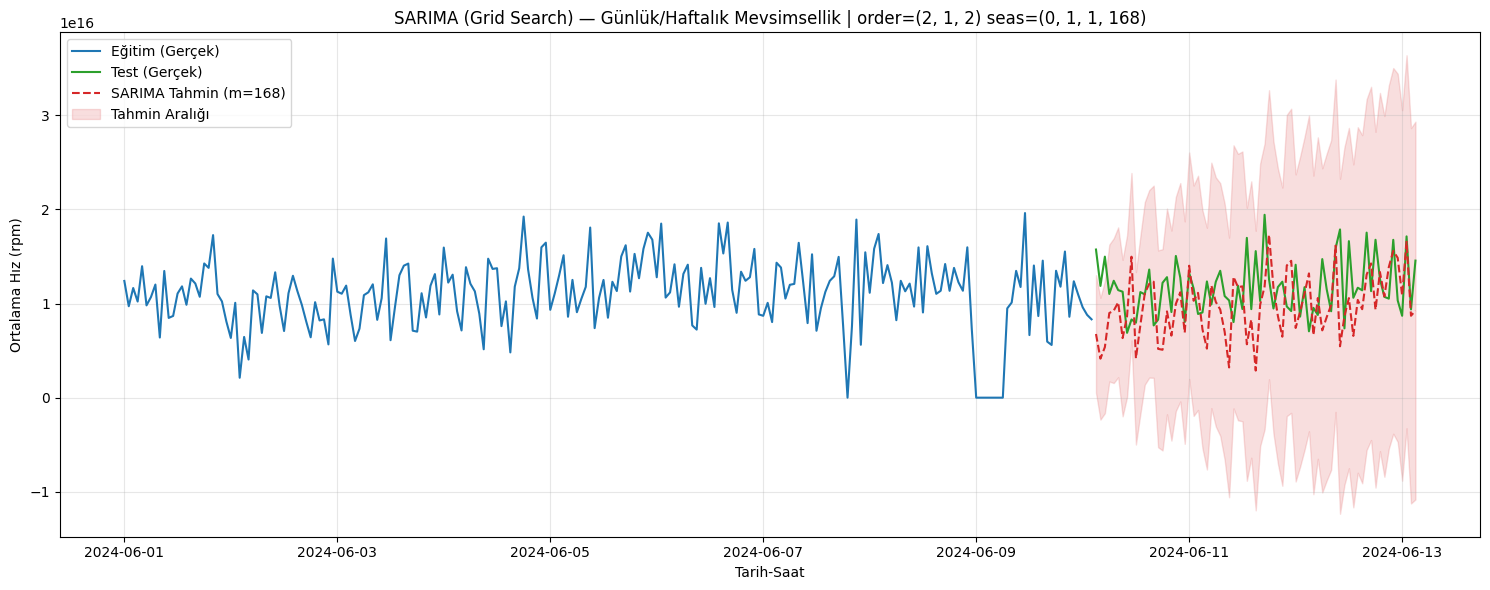

In [24]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, warnings
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

# ---------- 1) Zaman serisini hazırla ----------
df = df_hour.copy()
# saat kolonu adı sizde 'hour' ise; değilse 'Date/Tarih/timestamp' kontrol edin
time_col = None
for c in df.columns:
    if c.lower() in ["hour", "date", "tarih", "timestamp"]:
        time_col = c; break
if time_col is None:
    raise ValueError("Zaman kolonu bulunamadı.")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
#df = df.dropna(subset=[time_col, "ortalama_hiz"]).sort_values(time_col)

# Aynı saate düşen kayıtları tekilleştir, düzenli ızgaraya al, eksikleri doldur
ser = (df.groupby(df[time_col].dt.floor("h"))["ortalama_hiz"].mean()
         .asfreq("h"))
ser = ser.interpolate(limit_direction="both")

# Ölçekleme (sayısal stabilite için)
scale = 1e6
y = ser / scale

# ---------- 2) Train/Valid/Test böl ----------
n = len(y)
i_train = int(n*0.75)
y_train, y_test = y.iloc[:i_train], y.iloc[i_train:]

# Train içinde AIC’ye bakmak için minik bir validasyon (son %10’u validasyon)
i_val = int(len(y_train)*0.9)
y_tr, y_val = y_train.iloc[:i_val], y_train.iloc[i_val:]

# ---------- 3) Grid-search ----------
def fit_sarima(endog, order, seas, exog=None):
    model = SARIMAX(endog, order=order, seasonal_order=seas,
                    enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

# Küçük ama anlamlı adaylar
pdq  = [(0,1,1), (1,1,1), (2,1,1), (2,1,2)]
PDQ  = [(0,1,1), (1,1,1)]
Ms   = [24, 168]  # günlük ve haftalık

cands = []
for m in Ms:
    for (p,d,q), (P,D,Q) in product(pdq, PDQ):
        try:
            res = fit_sarima(y_tr, (p,d,q), (P,D,Q,m))
            # validasyon RMSE
            fc_val = res.get_forecast(steps=len(y_val)).predicted_mean
            rmse_val = math.sqrt(mean_squared_error(y_val, fc_val))
            cands.append({
                "m": m, "order": (p,d,q), "seas": (P,D,Q,m),
                "aic": res.aic, "rmse_val": rmse_val
            })
        except Exception:
            pass

if not cands:
    raise RuntimeError("Hiçbir SARIMA adayı başarıyla fit edilemedi.")

# Önce validasyon RMSE’ye göre, eşitlikte AIC’ye göre seç
best = sorted(cands, key=lambda x: (x["rmse_val"], x["aic"]))[0]
print(f"[Seçilen] m={best['m']} order={best['order']} seasonal_order={best['seas']}"
      f" | valid RMSE={best['rmse_val']:.4f} (ölçekli)")

# ---------- 4) En iyi modelle train (tam) → test tahmini ----------
res_best = fit_sarima(y_train, best["order"], best["seas"])
fc_test = res_best.get_forecast(steps=len(y_test))
yhat_test = fc_test.predicted_mean
ci = fc_test.conf_int(alpha=0.2)  # %80 bant

# Orijinal ölçeğe çevir
y_train_lin = y_train * scale
y_test_lin  = y_test  * scale
yhat_lin    = yhat_test * scale
ci_lin      = ci * scale

# ---------- 5) Metrikler ----------
rmse = math.sqrt(mean_squared_error(y_test_lin, yhat_lin))
mae  = mean_absolute_error(y_test_lin, yhat_lin)
mape = np.mean(np.abs((y_test_lin - yhat_lin) / np.where(y_test_lin==0, 1e-8, y_test_lin))) * 100
print(f"Test RMSE={rmse:,.2f}  MAE={mae:,.2f}  MAPE={mape:.2f}%")

# ---------- 6) Grafik ----------
plt.figure(figsize=(15,6))
plt.plot(y_train_lin.index, y_train_lin.values, label="Eğitim (Gerçek)", color="C0")
plt.plot(y_test_lin.index,  y_test_lin.values,  label="Test (Gerçek)",    color="C2")
plt.plot(yhat_lin.index,    yhat_lin.values,    label=f"SARIMA Tahmin (m={best['m']})", color="C3", linestyle="--")
plt.fill_between(ci_lin.index, ci_lin.iloc[:,0], ci_lin.iloc[:,1], color="C3", alpha=0.15, label="Tahmin Aralığı")
plt.title(f"SARIMA (Grid Search) — Günlük/Haftalık Mevsimsellik | order={best['order']} seas={best['seas']}")
plt.xlabel("Tarih-Saat"); plt.ylabel("Ortalama Hız (rpm)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
